# INR Classification with Neural Graphs

A quick start notebook for performing INR classification with Neural Graphs.

**Make sure you change the runtime type to GPU before starting!**

In [ ]:
# if not installed already, please install neural-graphs and all its dependencies.
! git clone https://github.com/mkofinas/neural-graphs.git

In [ ]:
cd neural-graphs

In [ ]:
!pip install -e .

## Import Dependencies

In [1]:
%matplotlib inline

import logging
from pathlib import Path

import matplotlib.pyplot as plt
from omegaconf import OmegaConf
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
import torch_geometric.utils
import torchvision
from tqdm import trange
import wandb

from experiments.data import INRDataset
from experiments.utils import count_parameters, set_logger, set_seed
from experiments.lr_scheduler import WarmupLRScheduler
from nn.relational_transformer import RelationalTransformer

from nn.gnn import GNNForClassification
from nn.dws.models import MLPModelForClassification
from nn.inr import INRPerLayer

set_logger()

## Get Data
Next, we download the MNIST INR dataset and place it in `../experiments/inr-classification/dataset/mnist-inrs`.

In [30]:
!mkdir -p ../experiments/inr_classification/dataset/mnist-inrs

In [ ]:
!wget "https://www.dropbox.com/sh/56pakaxe58z29mq/AABrctdu2U65jGYr2WQRzmMna/mnist-inrs.zip?dl=0" -O mnist-inrs.zip

In [32]:
!unzip -q mnist-inrs.zip -d ../experiments/inr_classification/dataset

In [33]:
!rm mnist-inrs.zip

## Data preprocessing

We have already performed the data preprocessing required for MNIST and provide the files with the repository. The preprocessing includes the data splits and the dataset statistics, corresponding to the files `../experiments/inr_classification/dataset/mnist_splits.json` and `../experiments/inr_classification/dataset/mnist_statistics.pth`, respectively. However, if you want to use different directories for your experiments, you have to run the scripts that follow.

### Preprocess
We create the data split using:
```shell
python ../experiments/inr_classification/dataset/generate_mnist_data_splits.py \
  --data-path mnist-inrs --save-path . --name mnist_splits.json
```
This will create a json file `mnist_splits.json` in `../experiments/inr_classification/dataset/`.

Next, we compute the dataset (INRs) statistics:
```shell
python ../experiments/inr_classification/dataset/compute_mnist_statistics.py \
  --splits-path mnist_splits.json --statistics-path mnist_statistics.pth
```
This will create `mnist_statistics.pth` in `../experiments/inr_classification/dataset/`. Note that this script will take a few minutes.

In [ ]:
# Create dataset splits (train/val/test)
%run ../experiments/inr_classification/dataset/generate_mnist_data_splits.py \
  --data-path mnist-inrs --save-path . --name mnist_splits.json

# compute dataset statistics - could take few minutes
%run ../experiments/inr_classification/dataset/compute_mnist_statistics.py \
  --splits-path mnist_splits.json --statistics-path mnist_statistics.pth

## INR Dataset

We create INR Datasets and Dataloaders, and visualize some INRs (by reconstruction the images).

### INR Reconstruction

First let's take a look at some INRs and INR augmentations

In [2]:
dataset_dir = "../experiments/inr_classification/dataset"
splits_path = "mnist_splits.json"
statistics_path = "mnist_statistics.pth"
img_shape = (28, 28)
batch_size = 64

In [4]:
orig_mnist = torchvision.datasets.MNIST(
    Path(dataset_dir) / "mnist",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)

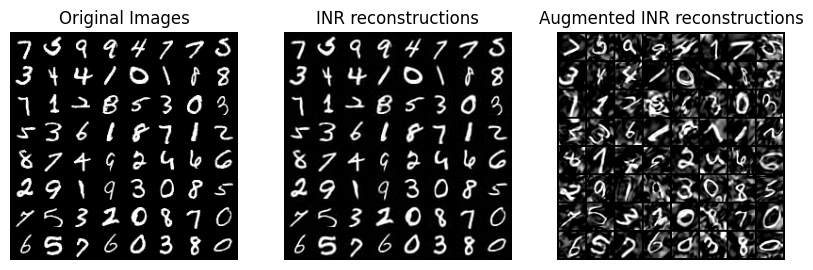

In [5]:
from torchvision.utils import save_image, make_grid

from experiments.data import BatchSiren, INRDataset

dataset = INRDataset(
    dataset_dir=dataset_dir,
    split="train",
    normalize=False,
    augmentation=False,
    splits_path=splits_path,
    statistics_path=statistics_path,
)
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
batch = next(iter(loader))

dataset_aug = INRDataset(
    dataset_dir=dataset_dir,
    split="train",
    normalize=False,
    augmentation=True,
    splits_path=splits_path,
    statistics_path=statistics_path,
)
loader_aug = torch.utils.data.DataLoader(
    dataset_aug, batch_size=batch_size, shuffle=False
)
batch_aug = next(iter(loader_aug))

inr_model = BatchSiren(2, 1, img_shape=img_shape)
out = inr_model(batch.weights, batch.biases)
out = out.transpose(1, 2).unflatten(2, img_shape)

out_aug = inr_model(batch_aug.weights, batch_aug.biases)
out_aug = out_aug.transpose(1, 2).unflatten(2, img_shape)

indices = [
    int(p.parts[-3].split("_")[-1]) for p in dataset.dataset["path"][:batch_size]
]
orig_images = [orig_mnist[idx][0] for idx in indices]

fig, ax = plt.subplots(1, 3, figsize=(10, 20))

ax[0].imshow(make_grid(orig_images).permute(1, 2, 0).clip(0, 1))
ax[0].set_title("Original Images")
ax[0].set_axis_off()

ax[1].imshow(make_grid(out).permute(1, 2, 0).clip(0, 1))
ax[1].set_title("INR reconstructions")
ax[1].set_axis_off()

ax[2].imshow(make_grid(out_aug).permute(1, 2, 0).clip(0, 1))
ax[2].set_title("Augmented INR reconstructions")
ax[2].set_axis_off()

In [3]:
train_set = INRDataset(
    dataset_dir=dataset_dir,
    split="train",
    normalize=False,
    augmentation=True,
    splits_path=splits_path,
    statistics_path=statistics_path,
)
val_set = INRDataset(
    dataset_dir=dataset_dir,
    split="val",
    normalize=False,
    splits_path=splits_path,
    statistics_path=statistics_path,
)

test_set = INRDataset(
    dataset_dir=dataset_dir,
    split="test",
    normalize=False,
    splits_path=splits_path,
    statistics_path=statistics_path,
)

---

### Create Dataloaders

In [4]:
batch_size = 64
num_workers = 8

train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
)
val_loader = torch.utils.data.DataLoader(
    dataset=val_set,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
    pin_memory=True,
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
)

logging.info(
    f"train size {len(train_set)}, "
    f"val size {len(val_set)}, "
    f"test size {len(test_set)}"
)

2024-02-22 20:37:03,779 - root - INFO - train size 55000, val size 5000, test size 10000


Let's look at the input INRs' shapes: Weight matrices are of shapes (in_dim, out_dim, channels), and biases are of shape (out_dim, channels).

In [5]:
point = train_set.__getitem__(0)
print(list(point.as_dict().keys()))

# weights
print("Weights:", [w.shape for w in point.weights])

# biases
print("Biases:", [b.shape for b in point.biases])

['weights', 'biases', 'label']
Weights: [torch.Size([2, 32, 1]), torch.Size([32, 32, 1]), torch.Size([32, 1, 1])]
Biases: [torch.Size([32, 1]), torch.Size([32, 1]), torch.Size([1, 1])]


---

## Initialize Neural Graphs Transformer

In [6]:
# get device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"device = {device}")

2024-02-22 20:37:06,369 - root - INFO - device = cuda


In [7]:
# Compute the layer layout
point = train_set[0]
weight_shapes = tuple(w.shape[:2] for w in point.weights)
bias_shapes = tuple(b.shape[:1] for b in point.biases)

layer_layout = [weight_shapes[0][0]] + [b[0] for b in bias_shapes]

logging.info(f"weight shapes: {weight_shapes}, bias shapes: {bias_shapes}")

2024-02-22 20:37:08,044 - root - INFO - weight shapes: (torch.Size([2, 32]), torch.Size([32, 32]), torch.Size([32, 1])), bias shapes: (torch.Size([32]), torch.Size([32]), torch.Size([1]))


In [8]:
stats = {
    "weights_mean": [
        -4.215954686515033e-05,
        -7.55547659991862e-07,
        7.886120874900371e-05,
    ],
    "weights_std": [0.06281130015850067, 0.018268151208758354, 0.11791174858808517],
    "biases_mean": [
        5.419965418695938e-06,
        3.7173406326473923e-06,
        -0.01239530649036169,
    ],
    "biases_std": [0.021334609016776085, 0.011004417203366756, 0.09989194571971893],
}

In [12]:
# inr_model = INRPerLayer(n_layers=3, up_scale=16, out_channels=1)

inr_model = None
d_node = 64
d_edge = 32

graph_constructor = OmegaConf.create(
    {
        "_target_": "nn.graph_constructor.GraphConstructor",
        "_recursive_": False,
        "_convert_": "all",
        "d_in": 1,
        "d_edge_in": 1,
        "zero_out_bias": False,
        "zero_out_weights": False,
        "sin_emb": True,
        "sin_emb_dim": 128,
        "use_pos_embed": True,
        "input_layers": 1,
        "inp_factor": 1,
        "num_probe_features": 0,
        "inr_model": inr_model,
        "stats": stats,
    }
)

model = RelationalTransformer(
    d_node=d_node,
    d_edge=d_edge,
    d_attn_hid=128,
    d_node_hid=128,
    d_edge_hid=64,
    d_out_hid=128,
    d_out=10,
    n_layers=4,
    n_heads=8,
    layer_layout=layer_layout,
    graph_constructor=graph_constructor,
    dropout=0.0,
    use_cls_token=False,
    pooling_method="cat",
    pooling_layer_idx="last",
).to(device)

In [13]:
logging.info(f"number of parameters: {count_parameters(model)}")

2024-02-22 20:31:04,077 - root - INFO - number of parameters: 376586


## Eval Function

In [14]:
@torch.no_grad()
def evaluate(model, loader, device, num_batches=None):
    model.eval()
    loss = 0.0
    correct = 0.0
    total = 0.0
    predicted, gt = [], []
    for i, batch in enumerate(loader):
        if num_batches is not None and i >= num_batches:
            break
        batch = batch.to(device)
        inputs = (batch.weights, batch.biases)
        out = model(inputs)
        loss += F.cross_entropy(out, batch.label, reduction="sum")
        total += len(batch.label)
        pred = out.argmax(1)
        correct += pred.eq(batch.label).sum()
        predicted.extend(pred.cpu().numpy().tolist())
        gt.extend(batch.label.cpu().numpy().tolist())

    model.train()
    avg_loss = loss / total
    avg_acc = correct / total

    return dict(avg_loss=avg_loss, avg_acc=avg_acc, predicted=predicted, gt=gt)

## Model training

In [13]:
parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(
    params=parameters, lr=1e-3, amsgrad=True, weight_decay=5e-4, fused=False
)
scheduler = WarmupLRScheduler(warmup_steps=1000, optimizer=optimizer)

In [21]:
epochs = 50  # doing just 50 epochs here
eval_every = 500

global_step = 0
criterion = nn.CrossEntropyLoss()

val_acc = -1
val_loss = float("inf")
best_val_acc = -1
best_val_loss = float("inf")

In [15]:
epoch_iter = trange(epochs)
for epoch in epoch_iter:
    for i, batch in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()

        batch = batch.to(device)
        inputs = (batch.weights, batch.biases)
        label = batch.label

        out = model(inputs)
        loss = criterion(out, label)
        loss.backward()

        optimizer.step()

        if scheduler is not None:
            scheduler.step()

        epoch_iter.set_description(
            f"[{epoch} {i+1}], train loss: {loss.item():.3f}, val loss: {val_loss:.3f}, val acc: {val_acc:.3f}, "
            f"best val loss: {best_val_loss:.3f}, best val acc: {best_val_acc:.3f}"
        )

        global_step += 1

        if (global_step + 1) % eval_every == 0:
            val_loss_dict = evaluate(model, val_loader, device)
            val_loss = val_loss_dict["avg_loss"]
            val_acc = val_loss_dict["avg_acc"]

            best_val_criteria = val_acc >= best_val_acc
            if best_val_criteria:
                best_val_acc = val_acc
                best_val_loss = val_loss

[49 860], train loss: 0.046, val loss: 0.268, val acc: 0.914, best val loss: 0.250, best val acc: 0.921: 100%|██████████████████████████████████████████████| 50/50 [2:29:41<00:00, 179.62s/it]


In [16]:
test_loss_dict = evaluate(model, test_loader, device)
test_loss = test_loss_dict["avg_loss"]
test_acc = test_loss_dict["avg_acc"]

logging.info(
    f"[{epoch} {i+1}], train loss: {loss.item():.3f}, test loss: {test_loss:.3f}, test acc: {test_acc:.3f}"
)

2024-02-21 10:04:22,778 - root - INFO - [49 860], train loss: 0.046, test loss: 0.266, test acc: 0.913


---

## Initialize Neural Graphs Graph Neural Network

In [19]:
# inr_model = INRPerLayer(n_layers=3, up_scale=16, out_channels=1)
inr_model = None

graph_constructor = OmegaConf.create(
    {
        "_target_": "nn.graph_constructor.GraphConstructor",
        "_recursive_": False,
        "_convert_": "all",
        "d_in": 1,
        "d_edge_in": 1,
        "zero_out_bias": False,
        "zero_out_weights": False,
        "sin_emb": True,
        "sin_emb_dim": 128,
        "use_pos_embed": True,
        "input_layers": 1,
        "inp_factor": 1,
        "num_probe_features": 0,
        "inr_model": inr_model,
        "stats": stats,
    }
)

gnn_backbone = OmegaConf.create(
    {
        "_target_": "nn.gnn.PNA",
        "_convert_": "all",
        "in_channels": 32,
        "hidden_channels": 32,
        "out_channels": 32,
        "num_layers": 4,
        "aggregators": ["mean", "min", "max", "std"],
        "scalers": ["identity", "amplification"],
        "edge_dim": 32,
        "dropout": 0.1,
        "norm": "layernorm",
        "act": "silu",
        "deg": None,
        "update_edge_attr": True,  # Check with False as well
        "modulate_edges": True,
        "gating_edges": False,
        "final_edge_update": False,
    }
)

gnn_model = GNNForClassification(
    d_hid=32,
    d_out=10,
    graph_constructor=graph_constructor,
    gnn_backbone=gnn_backbone,
    layer_layout=layer_layout,
    rev_edge_features=False,
    pooling_method="cat",
    pooling_layer_idx="last",
).to(device)

In [ ]:
logging.info(f"number of parameters: {count_parameters(model)}")

## Model training

In [20]:
gnn_parameters = [p for p in gnn_model.parameters() if p.requires_grad]
gnn_optimizer = torch.optim.AdamW(
    params=gnn_parameters, lr=1e-3, amsgrad=True, weight_decay=5e-4, fused=False
)
scheduler = WarmupLRScheduler(warmup_steps=1000, optimizer=gnn_optimizer)

In [21]:
epochs = 50  # doing just 50 epochs here
eval_every = 500

global_step = 0
criterion = nn.CrossEntropyLoss()

val_acc = -1
val_loss = float("inf")
best_val_acc = -1
best_val_loss = float("inf")

In [24]:
epoch_iter = trange(epochs)
for epoch in epoch_iter:
    for i, batch in enumerate(train_loader):
        gnn_model.train()
        gnn_optimizer.zero_grad()

        batch = batch.to(device)
        inputs = (batch.weights, batch.biases)
        label = batch.label

        out = gnn_model(inputs)
        loss = criterion(out, label)
        loss.backward()

        gnn_optimizer.step()

        if scheduler is not None:
            scheduler.step()

        epoch_iter.set_description(
            f"[{epoch} {i+1}], train loss: {loss.item():.3f}, val loss: {val_loss:.3f}, val acc: {val_acc:.3f}, "
            f"best val loss: {best_val_loss:.3f}, best val acc: {best_val_acc:.3f}"
        )

        global_step += 1

        if (global_step + 1) % eval_every == 0:
            val_loss_dict = evaluate(gnn_model, val_loader, device)
            val_loss = val_loss_dict["avg_loss"]
            val_acc = val_loss_dict["avg_acc"]

            best_val_criteria = val_acc >= best_val_acc
            if best_val_criteria:
                best_val_acc = val_acc
                best_val_loss = val_loss

[49 860], train loss: 0.640, val loss: 0.493, val acc: 0.828, best val loss: 0.488, best val acc: 0.843: 100%|█████████████████████████████████████████████████| 50/50 [39:30<00:00, 47.41s/it]


In [ ]:
test_loss_dict = evaluate(model, test_loader, device)
test_loss = test_loss_dict["avg_loss"]
test_acc = test_loss_dict["avg_acc"]

logging.info(
    f"[{epoch} {i+1}], train loss: {loss.item():.3f}, test loss: {test_loss:.3f}, test acc: {test_acc:.3f}"
)